## ResVe v4.2 
Eliminating matching CNN and trianing directly on resnet and word embeddings

In [1]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as data
import os
import time
import pickle
import numpy as np
from PIL import Image
import re
import io
import os 

import json
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors


from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb

torch.manual_seed(42)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

True

In [2]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def save_json(file_path, data):
    out_file = open(file_path, "w")
    json.dump(data, out_file)
    out_file.close()

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

### Bar to visualize progress

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
# IMAGES
im_path_fur = '/home/ubuntu/ADARI/images/v2/full'

# WORD EMBEDDINGS
word_embeddings_path = "../json_files/fur_5c_50d_sk_glove_ft.json"
word_embeddings_path2 = "../json_files/fur_v2_5c_50d_adjs.json"

# IMAGE EMBEDDINGS
img_embds_id_p = "../json_files/afur_resnet_emb_id.json"
img_embds_name_p = "../json_files/afur_resnet_emb_names.json"

# FILES FOR DATALOADER
dset_words_p = "../json_files/ADARI_furniture_words.json"
vocab_p = "../json_files/ADARI_furniture_vocab_adjs.json"

In [5]:
# Open json files with embeddings 
image_embeddings = open_json(img_embds_name_p) 
dataset_labels = open_json(dset_words_p)        # dictionary image: list of adjectives 
labels_embeddings = open_json(word_embeddings_path)
labels_embeddings_v2 = open_json(word_embeddings_path2)
vocab = open_json(vocab_p)                      # vocab only adjectives 

In [6]:
len(vocab)

7491

In [7]:
def sampling_rate_and_negative_sample(vocab, w2i):
    # Returns sampling rate of word (prob of keeping the word ) and negative sampling rate
    # 1) variables for sampling_rate
    
    frequencies_ids = dict()
    frequencies = dict()
    total_number_words = sum(vocab.values())
    threshold = 1e-5
    for word, count in vocab.items():
        # for sampling rate 
        z_w = count / total_number_words # this all add up to 1
        frequencies[word] = z_w
        w_id = w2i[word]
        frequencies_ids[w_id] = z_w

    # Noise_dist
    noise_dist = {key:val**(3/4) for key, val in frequencies.items()}
    
    # Frequency of dropping
    p_drop = {word: 1 - np.sqrt(threshold/frequencies[word]) for word in vocab}
    
    # Noise dist normalized 
    Z = sum(noise_dist.values())
    neg_sampling = dict()
    neg_sampling_ids = dict()
    
    for k, v in noise_dist.items():
        k_id = w2i[k]
        n_s_value = v/Z
        neg_sampling[k] = n_s_value
        neg_sampling_ids[k_id] = n_s_value

    return frequencies, frequencies_ids, neg_sampling, neg_sampling_ids, p_drop

In [8]:
def im2idx_w2idx(im_words, vocab):
    # The 2 dictionaries below for dataset dataloader
    im2idx = dict()
    idx2im = dict()
    w2i = dict()
    i2w = dict()
    for i,image_name in enumerate(im_words.keys()):
        im2idx[image_name] = i
        idx2im[i] = image_name

    for i, w in enumerate(vocab.keys()):
        w2i[w] = i
        i2w[i] = w
    
    return im2idx, idx2im, w2i, i2w

In [9]:
im2id, id2im, w2i, i2w = im2idx_w2idx(dataset_labels, vocab)
s_rate, s_rate_ids, n_rate, n_rate_ids, p_drop = sampling_rate_and_negative_sample(vocab, w2i)

### Split dataset into train, validation and test

In [10]:
import random

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)
    return d

def splitDict(d_img_words, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    d_img_words = shuffle_dict(d_img_words)
    
    im_words = iter(d_img_words.items())      
    
    # Image - words
    dtrain = dict(itertools.islice(im_words, train_n))  
    dtest= dict(itertools.islice(im_words, test_n))   
    dval= dict(itertools.islice(im_words, val_n))
    
    # Save jsons 
    path = './train_test_val_mCNN/'
    os.makedirs(path)
    save_json('./train_test_val_mCNN/trainset.json', dtrain)
    save_json('./train_test_val_mCNN/testset.json', dtest)
    save_json('./train_test_val_mCNN/valset.json', dval)

    print('trainset size: ', len(dtrain), 'trainset dataset size: ',len(dtest), 'val set size: ', len(dval))
    return dtrain, dtest, dval

### If already created the split dataset, just load the json files

In [11]:
#dtrain_w, dtest_w, dval_w = splitDict(dataset_labels, .95, 500)

In [12]:
dtrain_w = open_json('./train_test_val_mCNN/trainset.json')
dtest_w = open_json('./train_test_val_mCNN/testset.json')
dval_w = open_json('./train_test_val_mCNN/valset.json')

In [13]:
img_size = 64
class ADARIdataset(Dataset):
    """
    Receives images and labels.
    Returns tensor image and tensor labels
    """
    def __init__(self, labels_data, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, img_path):

        self.labels_data = labels_data   # dictionary of images -> labels
        
        self.images_names = list(self.labels_data.keys())    # names
        self.images_embeds = list(image_embeddings.values()) # values
        
        self.w2i = w2i
        self.i2w = i2w
        self.im2id = im2id
        self.id2im = id2im
        
        self.sampling_r = s_rate
        self.neg_sampling = n_rate
        self.pdrop = p_drop
        
        self.image_path = img_path
        self.number_adjs = 1
        
    def __len__(self):
        return len(self.images_names)
    
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img
        
    def get_labels_embeddings_from_idx(self, idx):

        name_image = self.images_names[idx]
        labels = self.labels_data[name_image]
        
        # Set random distribution for setting a max number of labels = 10
        labels1 = np.random.choice(labels, self.number_adjs)
        labels2 = np.random.choice(labels, self.number_adjs)
        
        pos1_idxs = [self.w2i[l] for l in labels1]
        pos2_idxs = [self.w2i[l] for l in labels2]
        
        # Get positive and negative labels
        all_idx = list(self.w2i.values())
        pos_idxs = []
        
        # Remove indexes that correspond to the positive labels
        for l in labels:
            v2i = self.w2i[l]
            pos_idxs.append(v2i)
            
            if v2i in all_idx:
                all_idx.remove(v2i)
        
        # Choose random labels as negative samples -> this can be improved with info about distance of labels
        #neg_s_norm = [s/sum(all_idx) for s in all_idx]
        
        neg_idxs = np.random.choice(all_idx, self.number_adjs) #, p=neg_s_norm)
        
        neg_samples = []
        for n in neg_idxs:
            neg_samples.append(self.i2w[n])

        assert(len(labels1) == len(neg_samples))
        
        return torch.LongTensor(pos1_idxs), torch.LongTensor(pos2_idxs), torch.LongTensor(neg_idxs)
    
    def __getitem__(self, index):
        """
        Return tensor image and label index
        """
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)
        
        # Get embeddigns of labels
        pos1_idxs, pos2_idxs, neg_idxs = self.get_labels_embeddings_from_idx(index) # list size variable 
        return img, pos1_idxs, pos2_idxs, neg_idxs, name_image
 

In [14]:
dataset_train = ADARIdataset(dtrain_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_test = ADARIdataset(dtest_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_val = ADARIdataset(dval_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)


In [15]:
batch_size = 64
num_workers = 8 if cuda else 0

In [16]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

### Image embedding

In [17]:
feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    
    return model_ft, input_size

resnet, input_size = initialize_model(50, feature_extract)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
resnet.fc.weight.shape

torch.Size([50, 2048])

### Word embedding

In [20]:
def get_vocab_embeddings(vocab, labels_embeddings, labels_embeddings_v2):
    vocab_embeddings = dict()
    c = 0
    for word in vocab.keys():
        try:
            emb = labels_embeddings[word]
            c += 1
        except:
            emb = labels_embeddings_v2[word]
            c += 1
        vocab_embeddings[word] = emb
    return vocab_embeddings

In [21]:
def create_embedding_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.requires_grad = False
    
    return emb_layer #, num_embeddings, embedding_dim


vocab_embeddings = get_vocab_embeddings(vocab, labels_embeddings, labels_embeddings_v2)
# Fill vocabulary with pretrained vectors, if it exists. 
weights_matrix = torch.zeros((len(w2i), 50))

for w, id in w2i.items():
    try:
        weights_matrix[id] = torch.from_numpy(np.asarray(vocab_embeddings[w]))
    except KeyError:
        weights_matrix[id] = torch.from_numpy(np.random.normal(scale=0.6, size=(50,)))

In [22]:
class wordMLP(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embeddings = create_embedding_layer(weights_matrix, False)
        self.linear1 = nn.Linear(50, 50) # reshape later to (batch, 10, 50)
        
    def forward(self, inputs): # inputs [batch, 10]
        bs = inputs.shape[0]
        embeds = self.embeddings(inputs) # [batch, 50]
        embeds = embeds.view(bs, -1) # [batch, 50]
        out = self.linear1(embeds) 
        #out = out.view(bs, 10, 50)
        return out

### Metrics

In [23]:
def normalize_vec(vec):
    norm = vec.norm(p=2, dim=1, keepdim=True)
    vec_norm = vec.div(norm)
    return vec_norm

In [24]:
def R_at_K_batch(ground_truth, predictions, K):
    """
    ground_truth and predictions are [batch, 20]
    """
    batch = ground_truth.shape[0]
    running_batch = 0.0
    for b in range(batch):
        res = R_at_K(ground_truth[b], predictions[b], K)
        running_batch += res
    return running_batch / batch
    
def R_at_K(ground_truth, predictions, K):
    """
    Ground truth: vector with 10 idxs
    Predictions: vector with 10 idxs
    """
    ground_truth = ground_truth.tolist()
    predictions = predictions.tolist()
    total_right = 0
    for pred in predictions[:K]:
        if pred in ground_truth:
            total_right += 1
    r_at_k = total_right / len(ground_truth)
    return r_at_k

In [25]:
def make_one_hot(vector, N):
    """
    Return multihot vector with N entries
    """
    print('vector shape: ', vector.shape)
    batch = vector.shape[0]
    onehot = torch.zeros(batch, N, device=device).scatter_(1, vector.to(device), 1.)
    return onehot

In [26]:
def make_one_hot_onevector(vector, N):
    """
    Use this if batch=1
    Return multihot vector with N entries
    """
    onehot = torch.zeros(N, device=device)
    for idx in vector:
        onehot[idx] = 1.0
    return onehot

In [27]:
def calculate_metrics(target, preds, batch):
    """
    Calculates f1, precision, accuracy, lraps, mAP, auc weighted and unweighted
    """
    
    # Metrics 
    N = len(vocab)
    target = make_one_hot_onevector(target, N)
    SAMPLE_WEIGHT = compute_sample_weight('balanced', target.to("cpu"))
    preds = make_one_hot_onevector(preds, N)
    
    # WEIGHTED 
    f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro", sample_weight=SAMPLE_WEIGHT)*batch
    precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro",sample_weight=SAMPLE_WEIGHT)*batch
    accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*batch
    #lraps = label_ranking_average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*batch
    mAP = average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro",sample_weight=SAMPLE_WEIGHT)*batch
#     auc = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro", sample_weight=SAMPLE_WEIGHT)*batch
    

    # UNWEIGHTED
    f1_ = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch
    precision_ = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch
    accuracy_ = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*batch
    #lraps_ = label_ranking_average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*batch
    mAP_ = average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch
#     auc_ = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch

    
    return f1, precision, accuracy, 0, mAP, 0, f1_, precision_, accuracy_, 0, mAP_, 0

###  Train

In [28]:
def train_epoch(img_cnn, word_mlp, loader, optimizer, criterion):
    img_cnn.train()
    word_mlp.train()
    
    running_loss = 0.0

    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_lraps = 0.0
    running_map = 0.0
    running_auc = 0.0

    running_corrects_ = 0.0
    running_precision_ = 0.0
    running_accuracy_ = 0.0
    running_lraps_ = 0.0
    running_map_ = 0.0
    running_auc_ = 0.0
    
    running_r_at_k = [0.0, 0.0, 0.0]
    result = []
    result_ = []
    
    emb_words = list(vocab_embeddings.keys())
    embeds = list(vocab_embeddings.values())
    word_embeddings_np = np.asarray(embeds)
    
    start_time = time.time()
    for batch_idx, (data, pos1_idxs, pos2_idxs, neg_idxs, name_image) in enumerate(loader): 
        
        # Data to device 
        data = data.to(device)
        
        # Ground truth labels 
        pos1_idxs = pos1_idxs.to(device) # [batch, 10]
        pos2_idxs = pos2_idxs.to(device) # [batch, 10]
        neg_idxs = neg_idxs.to(device)   # [batch, 10]
        
        # image_CNN
        im_repres = img_cnn(data)     # [batch, 50]
        
        # word Embeddings
        pos1_label_embs = word_mlp(pos1_idxs).squeeze(1) # [batch, 10, 50]
        pos2_label_embs = word_mlp(pos2_idxs).squeeze(1)# [batch, 10, 50]
        neg_label_embs = word_mlp(neg_idxs).squeeze(1)  # [batch, 10, 50]
        
        # Triplet loss 
        loss = criterion(im_repres, pos1_label_embs, neg_label_embs)
        running_loss += loss.item() * data.shape[0]
        
        # Get label predictions (K-neighbors words of the image embedding)
        neigh = NearestNeighbors(n_neighbors=20) # initilize algorithm
        neigh.fit(word_embeddings_np)           # fit population (words)
        d, wids = neigh.kneighbors(im_repres.detach().cpu().numpy())   # find the 10 nearest words to the image
        preds = wids.squeeze()#.tolist() # array of indices type Long (int)
        
        # Metrics 
        targets = torch.cat((pos1_idxs, pos2_idxs), dim=1) #[batch, 20]
        
        # Recall @ K for k = 1, 5, 10
        K = [1,5,10]
        r_at_k_list = []
        
        for k in K:
            r_at_k = R_at_K_batch(targets, preds, k)
            r_at_k_list.append(r_at_k)
        
        for i, ratk in enumerate(r_at_k_list):
            running_r_at_k[i] += ratk * data.shape[0]
            
        f1, precision, accuracy, lraps, mAP, auc, f1_, precision_, accuracy_, lraps_, mAP_, auc_ = calculate_metrics(targets.long(), torch.from_numpy(preds), data.shape[0])
        
        running_corrects += f1
        running_precision += precision
        running_accuracy += accuracy
        running_lraps += lraps
        running_map += mAP
        running_auc += auc

        running_corrects_ += f1_
        running_precision_ += precision_
        running_accuracy_ += accuracy_
        running_lraps_ += lraps_
        running_map_ += mAP_
        running_auc_ += auc_

        if batch_idx % 50 == 0 and batch_idx != 0:
            print('loss: ', loss.item() * data.shape[0])
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()   # .backward() accumulates gradients
        

    end_time = time.time()
    
    # Epoch loss
    epoch_loss = running_loss / len(loader.dataset)
    
    # Epoch metrics 
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    epoch_auc = running_auc / len(loader.dataset)
    epoch_lraps = running_lraps / len(loader.dataset)
    epoch_map = running_map / len(loader.dataset)
    
    epoch_f1_ = running_corrects_ / len(loader.dataset)
    epoch_precision_ = running_precision_ / len(loader.dataset)
    epoch_acc_ = running_accuracy_ / len(loader.dataset)
    epoch_auc_ = running_auc_ / len(loader.dataset)
    epoch_lraps_ = running_lraps_ / len(loader.dataset)
    epoch_map_ = running_map_ / len(loader.dataset)
    
    # R@K metric
    for r in running_r_at_k:
        r = r/len(loader.dataset)
    
    print('------ Training -----')
    result.append('WEIGHTED Training Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f} mAP: {:.4f} lraps: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision, epoch_auc, epoch_map, epoch_lraps))
    print(result)
    result_.append('UNWEIGHTED Training Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f} mAP: {:.4f} lraps: {:.4f}'.format(epoch_loss, epoch_f1_, epoch_acc_, epoch_precision_, epoch_auc_, epoch_map_, epoch_lraps_))
    print(result_)
    print('R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k[0], running_r_at_k[1], running_r_at_k[2]))
    
    return epoch_loss, result, result_, epoch_f1, epoch_f1_, epoch_auc, epoch_auc_, epoch_lraps, epoch_lraps_, running_r_at_k

In [29]:
def test_epoch(img_cnn, word_mlp, loader, criterion):
    img_cnn.eval()
    word_mlp.eval()
    
    running_loss = 0.0 
    
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_lraps = 0.0
    running_map = 0.0
    running_auc = 0.0

    running_corrects_ = 0.0
    running_precision_ = 0.0
    running_accuracy_ = 0.0
    running_lraps_ = 0.0
    running_map_ = 0.0
    running_auc_ = 0.0
    
    running_r_at_k = [0.0, 0.0, 0.0]
    result = []
    result_ = []

    emb_words = list(vocab_embeddings.keys())
    embeds = list(vocab_embeddings.values())
    word_embeddings_np = np.asarray(embeds)
    
    with torch.no_grad():
        for batch_idx, (data, pos1_idxs, pos2_idxs, neg_idxs, name_image) in enumerate(loader):  
            
            # Data to device 
            data = data.to(device)
        
            # Ground truth labels 
            pos1_idxs = pos1_idxs.to(device) # [batch, 10]
            pos2_idxs = pos2_idxs.to(device) # [batch, 10]
            neg_idxs = neg_idxs.to(device)   # [batch, 10]
            
            # image_CNN
            im_repres = img_cnn(data) # [batch, 50]
            
            # word Embeddings
            pos1_label_embs = word_mlp(pos1_idxs).squeeze(1) # [batch, 50]
            pos2_label_embs = word_mlp(pos2_idxs).squeeze(1) # [batch, 50]
            neg_label_embs = word_mlp(neg_idxs).squeeze(1)   # [batch, 50]

            # Triplet loss 
            loss = criterion(im_repres, pos1_label_embs, neg_label_embs)
            running_loss += loss.item() * data.shape[0]

            # Get label predictions (K-neighbors words of the image embedding)
            neigh = NearestNeighbors(n_neighbors=20) # initilize algorithm
            neigh.fit(word_embeddings_np)           # fit population (words)
            d, wids = neigh.kneighbors(im_repres.detach().cpu().numpy())   # find the 10 nearest words to the image
            preds = wids.squeeze()#.tolist() # array of indices type Long (int)

            # Metrics 
            targets = torch.cat((pos1_idxs, pos2_idxs), dim=1) #[batch, 20]

            K = [1,5,10]
            r_at_k_list = []

            for k in K:
                r_at_k = R_at_K_batch(targets, preds, k)
                r_at_k_list.append(r_at_k)

            for i, ratk in enumerate(r_at_k_list):
                running_r_at_k[i] += ratk * data.shape[0]

            f1, precision, accuracy, lraps, mAP, auc, f1_, precision_, accuracy_, lraps_, mAP_, auc_ = calculate_metrics(targets.long(), torch.from_numpy(preds), data.shape[0])

            running_corrects += f1
            running_precision += precision
            running_accuracy += accuracy
            running_lraps += lraps
            running_map += mAP
            running_auc += auc

            running_corrects_ += f1_
            running_precision_ += precision_
            running_accuracy_ += accuracy_
            running_lraps_ += lraps_
            running_map_ += mAP_
            running_auc_ += auc_

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('loss: ', loss.item() * data.shape[0])
    
    # Epoch loss
    epoch_loss = running_loss / len(loader.dataset)
    
    # Epoch metrics 
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    epoch_auc = running_auc / len(loader.dataset)
    epoch_lraps = running_lraps / len(loader.dataset)
    epoch_map = running_map / len(loader.dataset)
    
    epoch_f1_ = running_corrects_ / len(loader.dataset)
    epoch_precision_ = running_precision_ / len(loader.dataset)
    epoch_acc_ = running_accuracy_ / len(loader.dataset)
    epoch_auc_ = running_auc_ / len(loader.dataset)
    epoch_lraps_ = running_lraps_ / len(loader.dataset)
    epoch_map_ = running_map_ / len(loader.dataset)
    
    # R@K metric
    for r in running_r_at_k:
        r = r/len(loader.dataset)
    
    print('------ Testing -----')
    result.append('WEIGHTED Testing Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f} mAP: {:.4f} lraps: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision, epoch_auc, epoch_map, epoch_lraps))
    print(result)
    result_.append('UNWEIGHTED Testing Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f} AUC: {:.4f} mAP: {:.4f} lraps: {:.4f}'.format(epoch_loss, epoch_f1_, epoch_acc_, epoch_precision_, epoch_auc_, epoch_map_, epoch_lraps_))
    print(result_)
    print('R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k[0], running_r_at_k[1], running_r_at_k[2]))
    
    return epoch_loss, result, result_, epoch_f1, epoch_f1_, epoch_auc, epoch_auc_, epoch_lraps, epoch_lraps_, running_r_at_k


In [30]:
# Metrics
from sklearn.metrics import precision_score, f1_score, accuracy_score, label_ranking_average_precision_score, average_precision_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# Models
device = torch.device("cuda" if cuda else "cpu")
image_CNN = resnet.to(device)
word_MLP = wordMLP(50).to(device)
criterion = nn.TripletMarginLoss(margin=0.5)

params_to_update = image_CNN.parameters()
if feature_extract:
    params_to_update = []
    for name, param in image_CNN.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in image_CNN.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

params = params_to_update + list(word_MLP.parameters()) 

optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr = 0.001)

	 fc.weight
	 fc.bias


#### Train loop

In [31]:
import warnings

In [28]:
def createCheckpoint(filename, batch_size, epoch, model):
    checkpoint = {
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
    } # save all important stuff
    torch.save(checkpoint , filename)

In [86]:
train_losses = []
test_losses = []

train_w_results = []
train_uw_results = []
test_w_results = []
test_uw_results = []

train_ratks = []
test_ratks = []

save_model_path = './saved_models/cnn_im_v4.2/'
if os.path.isdir(save_model_path) == False:
    os.makedirs(save_model_path)

best_loss = 1000.0
diff_train_test_losses = [1000]
for i in range(10):
    warnings.filterwarnings(action='ignore')
    print('-----Training epoch {}/{} --------'.format(i,9))
    tr_loss, tr_weighted_res, tr_unweighted_res, tr_w_f1, tr_uw_f1, \
    tr_w_auc, tr_uw_auc, tr_w_lraps, tr_uw_lraps, tr_ratk= train_epoch(image_CNN, word_MLP, train_dataloader, optimizer, criterion)
    print('train epoch: {}, loss: {}'.format(i, tr_loss))
    print()
    print('------Testing epoch {}/{} --------'.format(i,9))
    tst_loss, tst_weighted_res, tst_unweighted_res, tst_w_f1, tst_uw_f1, \
    tst_w_auc, tst_uw_auc, tst_w_lraps, tst_uw_lraps, tst_ratk = test_epoch(image_CNN, word_MLP, test_dataloader, criterion)
    print('test epoch: {}, loss: {}'.format(i, tst_loss))
    
    train_losses.append(tr_loss)
    test_losses.append(tst_loss)
    
    train_w_results.append(tr_weighted_res)
    train_uw_results.append(tr_unweighted_res)
    
    test_w_results.append(tst_weighted_res)
    test_uw_results.append(tst_unweighted_res)
    
    train_ratks.append(tr_ratk)
    test_ratks.append(tst_ratk)

    diff_train_test = np.absolute(tr_loss-tst_loss)


save_path_resnet = save_model_path + 'resnet_{}.pt'.format(i)
save_path_wordmlp = save_model_path + 'word_mlp_{}.pt'.format(i)
createCheckpoint(save_path_resnet, 64, i, image_CNN)
createCheckpoint(save_path_wordmlp, 64, i, word_MLP)

-----Training epoch 0/9 --------
loss:  9.848185539245605
loss:  6.553659915924072
loss:  11.914786338806152
loss:  16.0324764251709
loss:  13.644606590270996
------ Training -----
['WEIGHTED Training Loss: 0.2010 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.0000 mAP: nan lraps: 0.0004']
['UNWEIGHTED Training Loss: 0.2010 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.0000 mAP: nan lraps: 0.0004']
R@K=1: 0.5000  R@K=5: 12.0000 R@K=10: 20.5000
train epoch: 0, loss: 0.20099637627012207

------Testing epoch 0/9 --------
------ Testing -----
['WEIGHTED Testing Loss: 0.1595 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.0000 mAP: nan lraps: 0.0003']
['UNWEIGHTED Testing Loss: 0.1595 F1: 0.0000 Acc: 0.0000 Prec: 0.0000 AUC: 0.0000 mAP: nan lraps: 0.0003']
R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.5000
test epoch: 0, loss: 0.1594698626390645
-----Training epoch 1/9 --------
loss:  12.587745666503906
loss:  10.830168724060059
loss:  11.509572982788086
loss:  14.712960243225098
loss:  11.381413459777832
---

In [126]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):
    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.savefig('ADARI_resnet152_pretrained_adam0001.pdf', dpi=300)
    plt.savefig('ADARI_resnet152_pretrained_adam0001.png', dpi=300)
    plt.show()
    

In [127]:
epochs_list = [e for e in range(10)]

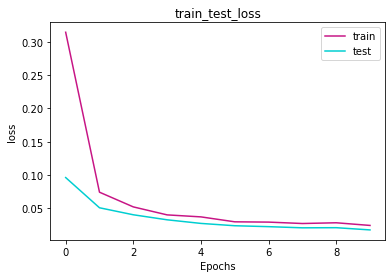

In [128]:
make_graph(epochs_list, train_losses, test_losses, 'train', 'test', 'train_test_loss', 'loss')

In [129]:
with open("train_losses", "w") as outfile:
    outfile.write("\n".join(str(item) for item in train_losses))
with open("test_losses", "w") as outfile:
    outfile.write("\n".join(str(item) for item in test_losses))

### SAVING EMBEDDINGS

#### Load checkpoint

In [51]:
save_model_path = './saved_models/cnn_im_v4.2/'
checkpoint = torch.load(save_model_path + "resnet_9.pt")
image_CNN.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

In [52]:
save_model_path = './saved_models/cnn_im_v4.2/'
checkpoint = torch.load(save_model_path + "word_mlp_9.pt")
word_MLP.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

#### Create embedding layer

In [34]:
save_path = 'mCNN_v4.2_word_embeddings.json'

In [32]:
class Embedding(object):
    def __init__(self, file_name, model):
        self.file_name = file_name
        self.create_embedding(model)
        self.save_json()

    def create_embedding(self, model):
        embeddings = model.embeddings.weight.cpu().data.numpy()
        self.embedding = {}
        for id, w in i2w.items():
            e = embeddings[id].tolist()
            self.embedding[w] = e
        
    def save_json(self):
        out_file = open(self.file_name, "w")
        json.dump(self.embedding, out_file)
        out_file.close()
    
E = Embedding(save_path, word_MLP)

In [48]:
WORD_EMBEDDINGS = open_json(save_path)

#### Create all image embeddings

In [49]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from torchvision.transforms import ToPILImage
import warnings

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,20))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

In [54]:
def get_image_tensor(image_name, im_path):
    """
    Gets image name and returns a tensor
    """
    name = im_path + "/" + image_name
    img = Image.open(name)
    img = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()])(img)
    return img


def get_im_embeddings(img_cnn, im_path):
    im_embds_name = list(image_embeddings.keys())  # names
    im_embds_emb = list(image_embeddings.values()) # embeddings
    
    all_embeds = dict()
    for name in im_embds_name:
        im = get_image_tensor(name, im_path).unsqueeze(0)
        emb_im = img_cnn(im.to(device)).squeeze(0).detach().cpu().numpy().reshape(1,-1) # [1,50]
        all_embeds[name] = emb_im
    return all_embeds

#all_embeds = get_im_embeddings(image_CNN, im_path_fur)

In [55]:
new_d = dict()
for k,v in all_embeds.items():
    new_d[k] = v.tolist()

save_json('mCNN_v4.2_image_embeddings.json', new_d)

In [56]:
IMAGE_EMBEDDINGS_RN = open_json('mCNN_v4.2_image_embeddings.json')